# Clusters - Classificação de clientes de e-commerce.

Neste projeto vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado as variáveis referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente e de temporalidade como época do ano (informações da data, como a proximidade a uma data especial, fim de semana e o mês). 

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

## Importando as bibliotecas e lendo a base.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

from scipy.cluster.hierarchy import linkage, fcluster
from gower import gower_matrix
from scipy.spatial.distance import pdist, squareform

import warnings

warnings.filterwarnings('ignore')
sns.set_palette(sns.color_palette("pastel"))

In [2]:
df = pd.read_csv('./input/online_shoppers_intention.csv')

In [3]:
df.head(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


In [4]:
#Contagem do valor de interesse
df.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [5]:
#identificação de valores nulos
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Analise exploratória

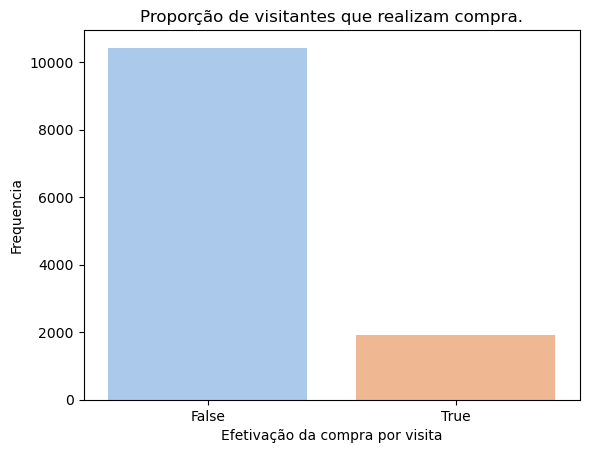

In [8]:
sns.countplot(data=df,x= 'Revenue')
plt.title('Proporção de visitantes que realizam compra.')
plt.xlabel('Efetivação da compra por visita')
plt.ylabel('Frequencia')
plt.show()

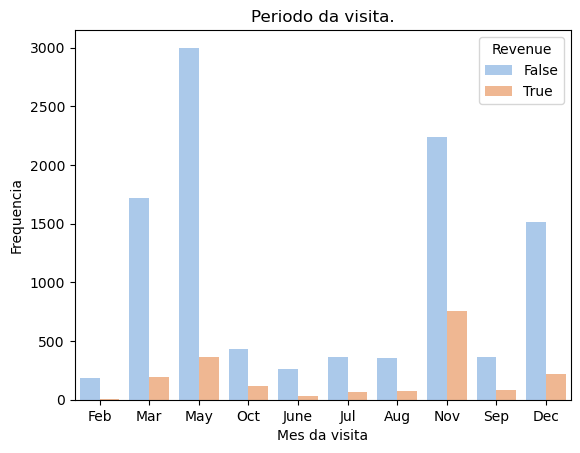

In [9]:
sns.countplot(data=df, x='Month', hue='Revenue')
plt.title('Periodo da visita.')
plt.xlabel('Mes da visita')
plt.ylabel('Frequencia')
plt.show()

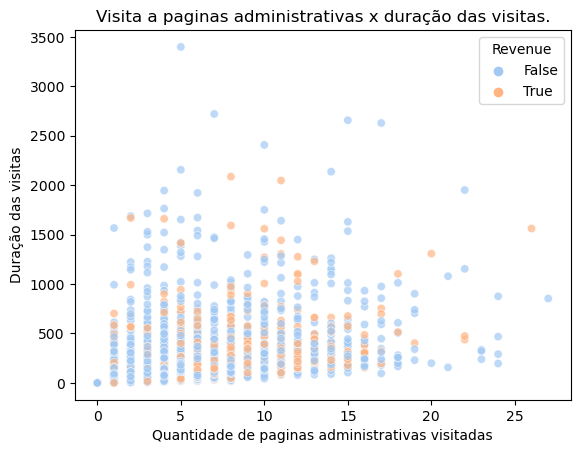

In [10]:
sns.scatterplot(data=df, x='Administrative', y='Administrative_Duration', hue='Revenue', alpha=0.7)
plt.title('Visita a paginas administrativas x duração das visitas.')
plt.xlabel('Quantidade de paginas administrativas visitadas')
plt.ylabel('Duração das visitas')
plt.show()

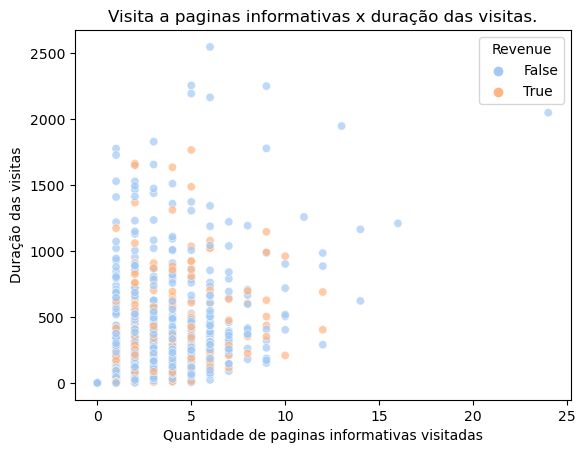

In [11]:
sns.scatterplot(data=df, x='Informational', y='Informational_Duration', hue='Revenue', alpha=0.7)
plt.title('Visita a paginas informativas x duração das visitas.')
plt.xlabel('Quantidade de paginas informativas visitadas')
plt.ylabel('Duração das visitas')
plt.show()

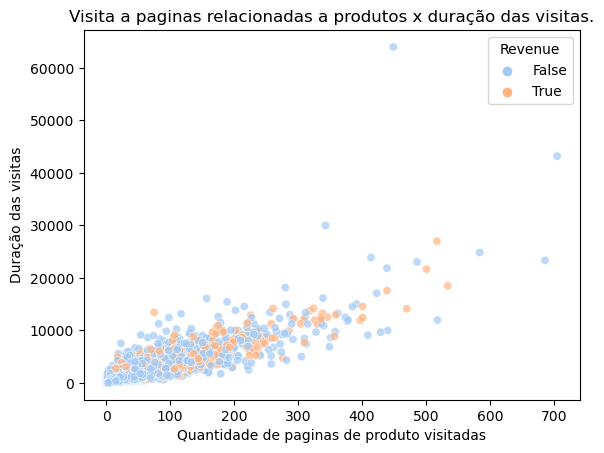

In [12]:
sns.scatterplot(data=df, x='ProductRelated', y='ProductRelated_Duration', hue='Revenue',alpha=0.7)
plt.title('Visita a paginas relacionadas a produtos x duração das visitas.')
plt.xlabel('Quantidade de paginas de produto visitadas')
plt.ylabel('Duração das visitas')
plt.show()

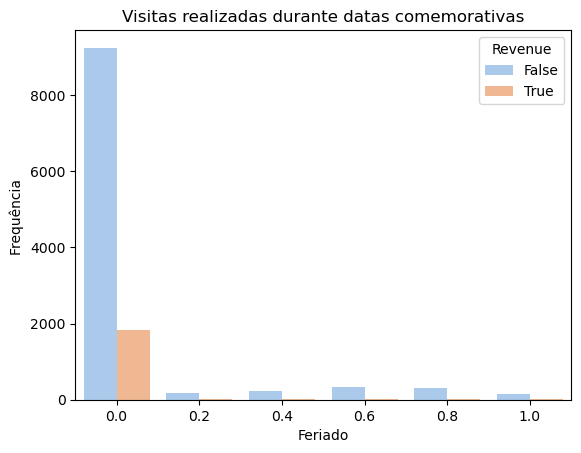

In [13]:
ax = sns.countplot(data=df, x='SpecialDay', hue='Revenue')

plt.title('Visitas realizadas durante datas comemorativas')
plt.xlabel('Feriado')
plt.ylabel('Frequência ')
plt.show()

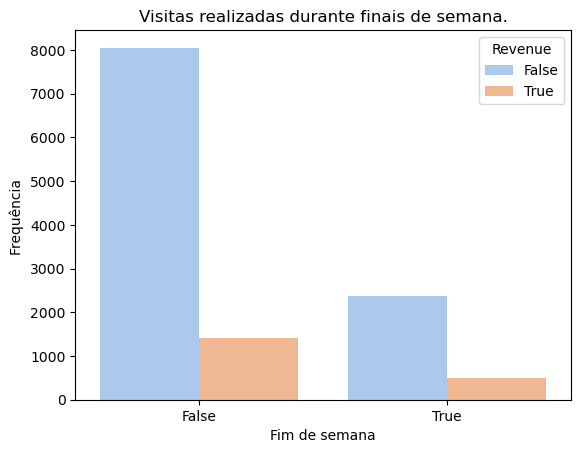

In [14]:
ax = sns.countplot(data=df, x='Weekend', hue='Revenue')
plt.title('Visitas realizadas durante finais de semana.')
plt.xlabel('Fim de semana')
plt.ylabel('Frequência ')
plt.show()

## Definição do número de cluster.

In [15]:
#tratamento das variaveis

# cria um dicionário de mapeamento dos meses para seus correspondentes numéricos
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'June': 6,
             'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

#tratamento da coluna e drop das colunas categoricas 

df_std = df.copy()
df_std['Month'] = df_std['Month'].replace(month_map)
df_std = df_std.drop('Revenue', axis=1)
df_std = df_std.drop('VisitorType', axis=1)

In [16]:
#variaveis de interesse quanto as paginas acessadas e periodo da visita
variaveis = [
    'Administrative', 'Informational', 'ProductRelated', 'Weekend',
    'SpecialDay', 'Month'
]

In [17]:
#padronização da escala das variaveis

df_std = pd.DataFrame(StandardScaler().fit_transform(df_std), columns = df_std.columns)

#retorno da variavel resposta
df_std['Revenue'] = df['Revenue']

In [18]:
med_por_grupo = df_std.groupby('Revenue').median()
med_por_grupo

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend
Revenue,,,,,,,,,,,,,,,,
False,-0.696993,-0.457191,-0.396478,-0.244931,-0.353725,-0.357734,-0.369920,-0.298415,-0.317178,-0.308821,-0.192173,-0.136078,-0.207952,-0.061364,-0.514182,-0.550552
True,-0.094882,-0.160953,-0.396478,-0.244931,-0.061418,-0.044335,-0.457683,-0.557116,0.585365,-0.308821,0.986828,-0.136078,-0.207952,-0.477771,-0.514182,-0.550552


In [19]:
#Encontrando as variaveis mais importantes
variaveis = med_por_grupo.abs().idxmax(axis=1).values
variaveis 

array(['Administrative', 'Month'], dtype=object)

In [20]:
#retorno da variabilidade por revenue
med_por_grupo[variaveis]

,Administrative,Month
Revenue,,
False,-0.696993,-0.192173
True,-0.094882,0.986828


In [21]:
import warnings

warnings.filterwarnings('ignore')

#metodo cotovelo para determinar o n_clusters
SQD = []
K = range(1, 5)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(df_std[variaveis])
    SQD.append(km.inertia_)

  0%|          | 0/4 [00:00<?, ?it/s]

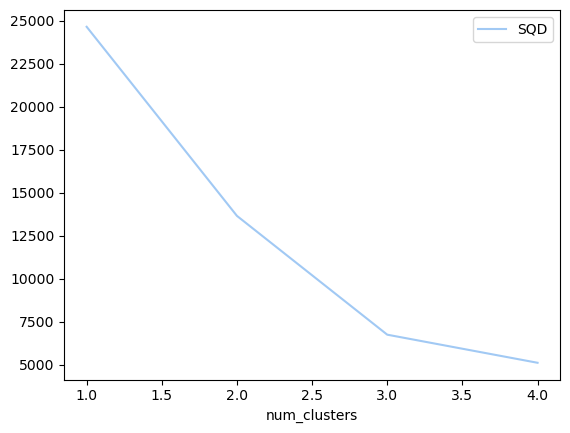

In [22]:
cotovelo = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
cotovelo.plot(x = 'num_clusters', y = 'SQD');

In [23]:
#Metodo silueta para determinar o n_clusters

# Inicializar uma lista vazia que vai conter os valores da silueta média
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 5

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(df_std[variaveis])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(df_std[variaveis], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
    df_std['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)

  0%|          | 0/4 [00:00<?, ?it/s]

<Axes: xlabel='n_clusters'>

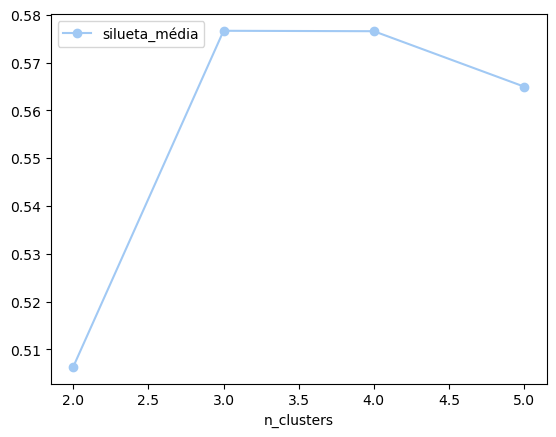

In [24]:
df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})

df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')

Ambos os metodos sugerem a divisão em 3 cluster.

## Agrupamento com diferentes tipo de dados.

In [25]:
#Aplicação do agrupamento pelo metodo gower matrix.
variaveis = [
    'Administrative', 'Informational', 'ProductRelated',
    'ProductRelated_Duration', 'Month'
]

variaveis_cat = variaveis[-1:]


In [26]:
df_1 = pd.get_dummies(df[variaveis])

In [27]:
vars_cat = [
    True if x in {
        'Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
        'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep'
    } else False for x in df_1.columns
]

In [28]:
%%time
distancia_gower = gower_matrix(df_1, cat_features=vars_cat)

CPU times: total: 9.14 s
Wall time: 9.18 s


In [29]:
#visualização das distancias
gdv = squareform(distancia_gower, force='tovector')
Z = linkage(gdv, method='complete')
Z_df = pd.DataFrame(Z, columns=['id1', 'id2', 'dist', 'n'])
Z_df.head()

,id1,id2,dist,n
0,0.0,2.0,0.0,2.0
1,6.0,12330.0,0.0,3.0
2,16.0,12331.0,0.0,4.0
3,24.0,12332.0,0.0,5.0
4,49.0,12333.0,0.0,6.0


In [30]:
#agrupamento de 3 grupos.
df['grupo'] = fcluster(Z, 3, criterion='maxclust')

In [31]:
df.groupby(['grupo', 'Revenue'
            ]).count().fillna(0)

Administrative  Administrative_Duration  Informational  \
grupo Revenue                                                           
1     False              2999                     2999           2999   
      True                365                      365            365   
2     False              4828                     4828           4828   
      True                707                      707            707   
3     False              2595                     2595           2595   
      True                836                      836            836   

               Informational_Duration  ProductRelated  \
grupo Revenue                                           
1     False                      2999            2999   
      True                        365             365   
2     False                      4828            4828   
      True                        707             707   
3     False                      2595            2595   
      True                        836             836   

               ProductRelated_Duration  BounceRates  ExitRates  PageValues  \
grupo Revenue                                                                
1     False                       2999         2999       2999        2999   
      True                         365          365        365         365   
2     False                       4828         4828       4828        4828   
      True                         707          707        707         707   
3     False                       2595         2595       2595        2595   
      True                         836          836        836         836   

               SpecialDay  Month  OperatingSystems  Browser  Region  \
grupo Revenue                                                         
1     False          2999   2999              2999     2999    2999   
      True            365    365               365      365     365   
2     False          4828   4828              4828     4828    4828   
      True            707    707               707      707     707   
3     False          2595   2595              2595     2595    2595   
      True            836    836               836      836     836   

               TrafficType  VisitorType  Weekend  
grupo Revenue                                     
1     False           2999         2999     2999  
      True             365          365      365  
2     False           4828         4828     4828  
      True             707          707      707  
3     False           2595         2595     2595  
      True             836          836      836

# Entendendo o comportamento dos grupos.

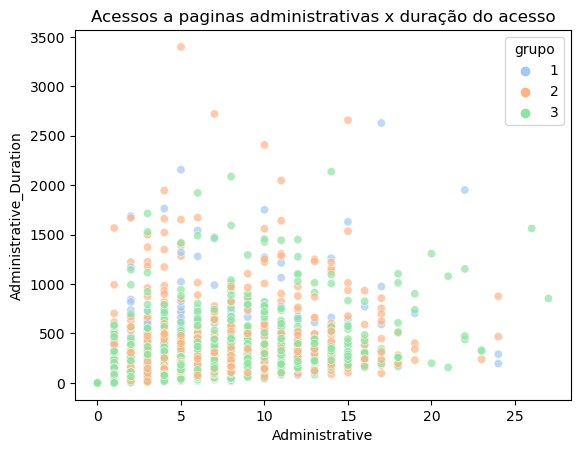

In [32]:
plt.title('Acessos a paginas administrativas x duração do acesso.')
sns.scatterplot(data=df, x='Administrative', y='Administrative_Duration', hue='grupo',alpha=0.7, palette="pastel")

plt.show()

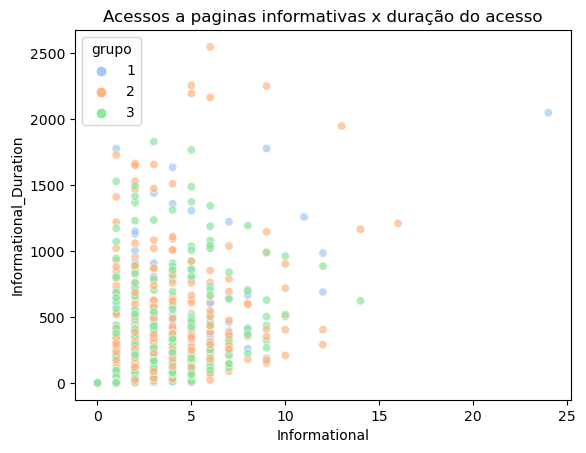

In [33]:
plt.title('Acessos a paginas informativas x duração do acesso.')
sns.scatterplot(data=df, x='Informational', y='Informational_Duration', hue='grupo',alpha=0.7, palette="pastel")
plt.show()

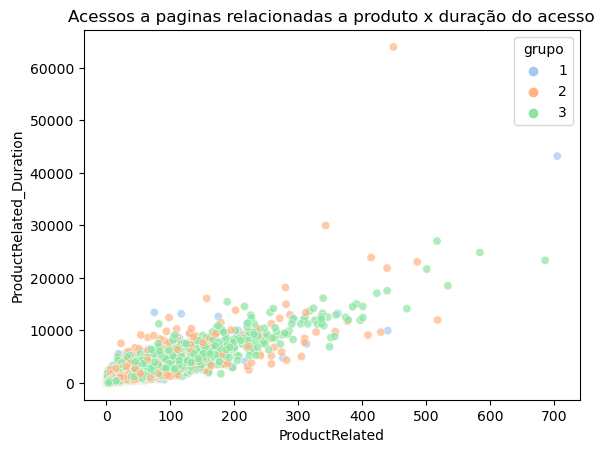

In [34]:
plt.title('Acessos a paginas relacionadas a produto x duração do acesso.')
sns.scatterplot(data=df, x='ProductRelated', y='ProductRelated_Duration', hue='grupo', alpha=.7, palette="pastel")
plt.show()

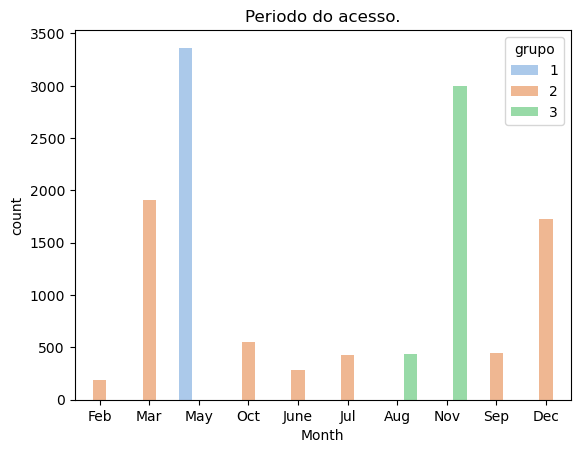

In [35]:
plt.title('Periodo do acesso.')
sns.countplot(data=df, x='Month', hue='grupo')
plt.show()

## Nomeando os grupos.

 **Grupo 1 --> Generosos**
 
 - O grupo dos Generosos procuram o site de e-commerce durante o mês de Maio, durante este mês acontecem duas datas comemorativas importantes, o dia das mães e dia dos pais nos estados unidos.
 
 **Grupo 2 --> Cliente fiel**
 
 - O grupo dos Fieis sempre compra no nosso e-commerce durante todo o ano.
 
 **Grupo 3 --> Caçadores de descontos**
 
 - Os caçadores adoram promoções especialmente durante a black friday e cyber monday durante o mês de novembro.
 
 

In [36]:
# cria um dicionário de mapeamento com personas para o Grupo de clientes
grupo_map = {1: 'Generoso', 2: 'Fiel', 3: 'Cacador'}

#tratamento da coluna

df['grupo'] = df['grupo'].replace(grupo_map)

In [37]:
df.groupby(['grupo']).count().fillna(0)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
grupo,,,,,,,,,,,,,,,,,,
Cacador,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431,3431
Fiel,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535,5535
Generoso,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364,3364


# Visualizando o comportamento dos grupos em relação a compras.

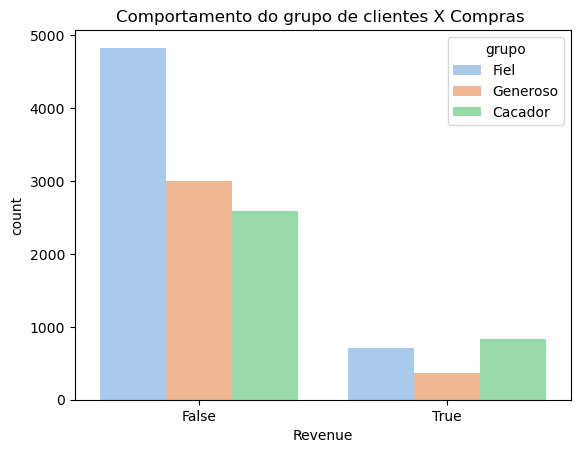

In [38]:
plt.title('Comportamento do grupo de clientes X Compras.')
sns.countplot(data=df, x='Revenue', hue='grupo')
plt.show()

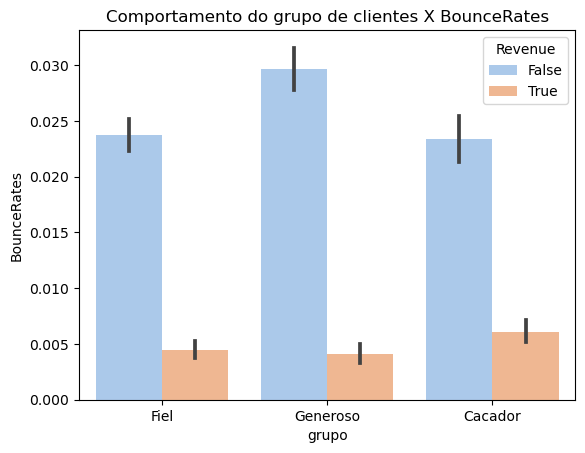

In [39]:
plt.title('Comportamento do grupo de clientes X BounceRates.')
sns.barplot(data=df, x='grupo', y='BounceRates', hue='Revenue')
plt.show()

### Concluções quanto ao perfil de consumo. 

**Fieis:**
    
- Os consumidores fieis são a maior parte dos nossos clientes;
- Tem o menor bounce rate (taxa de rejeição) entre os grupos;
    
**Generosos:**

- Tem taxas de rejeição maiores, pois são mais criteriosos.
    
**Caçadores:**
    
- Tem a maior propensão a realizar a  compra.
- Já sabem o que querem comprar, pois dentre os visitantes que realizam compras tem o maior valor de bounce rate, ou seja clicam no produto que querem e não visitam o restante do site.
    
### Ações dirigidas a cada grupo.


**Fieis:**
   

- *Programa de fidelidade:* ofereça benefícios exclusivos, descontos e recompensas para os clientes fieis. 
- *Conteúdo personalizado:* forneça conteúdo exclusivo e personalizado para os clientes fieis, como dicas, guias e informações relevantes relacionadas aos seus interesses. 
- *Comunicação frequente:* mantenha contato frequente com os clientes fieis por meio de e-mails, mensagens de texto, notificações de aplicativos, entre outros.

**Generosos:**


- *Atenção aos detalhes:* preste atenção aos detalhes do produto, incluindo descrição, imagens e informações sobre o uso e manutenção. 
- *Experiência de compra personalizada:* ofereça uma experiência de compra personalizada com base nas preferências e histórico de compras dos clientes generosos. 
- *Marketing de influência:* utilize influenciadores para promover seus produtos para os clientes generosos, já que eles são mais criteriosos.

**Caçadores**


- *Anúncios direcionados:* utilize anúncios direcionados para apresentar os produtos que os clientes caçadores estão procurando.
- *Descontos exclusivos:* ofereça descontos exclusivos para os produtos que os clientes caçadores já demonstraram interesse.
- *Facilidade de navegação:* facilite a navegação do site e torne mais fácil para os clientes caçadores encontrar o que estão procurando.